# AirBnb listings file modeling

In [46]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [47]:
import os
import seaborn as sns
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [48]:
data_path = ('/Users/Monu/Desktop/Data Mining Project/cleaned_with_nlp_listings.csv')
listings = pd.read_csv(data_path, index_col="id")

In [49]:
listings.head()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_count,desc_len,host_about_len,lreview_year,lreview_month,lreview_day,freview_year,freview_month,freview_day,ndays_between_f_l_reviews,ndays_host,ndays_last_review,num_amenities,host_response_time_na,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2454,60,0,1.0,1.0,1,0,1,2,1.0,0.0,2.0,137.0,150.0,50.0,1,0.0,7,730,7,7,730,730,7.0,730.0,16,36,65,65,1,1,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,1,0,0,1.00,2,412,0,2019.0,1.0,30.0,2019.0,1.0,30.0,0.0,3803,2.0,15,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2539,100,0,8.0,8.0,1,1,0,4,1.0,1.0,1.0,149.0,100.0,25.0,1,25.0,1,730,1,1,730,730,1.0,730.0,30,60,90,365,9,2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,8,0,5,3,0.23,4,392,431,2018.0,10.0,19.0,2015.0,12.0,4.0,15.0,3800,106.0,44,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0.000000,0.222222,0.777778,0.000000,0.000000,0.000000
2595,60,0,5.0,5.0,1,1,0,2,1.0,0.0,1.0,225.0,350.0,100.0,2,0.0,1,1125,1,1,1125,1125,1.0,1125.0,30,60,90,365,43,14,95.0,9.0,9.0,10.0,10.0,10.0,9.0,0,1,1,2,1,0,1,0.38,5,1000,427,2019.0,1.0,2.0,2009.0,11.0,21.0,19.0,3798,31.0,36,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.000000,0.232558,0.302326,0.093023,0.046512,0.325581
3330,100,0,4.0,4.0,1,1,1,2,1.0,1.0,1.0,70.0,150.0,125.0,2,50.0,5,730,5,5,730,730,5.0,730.0,2,27,37,290,39,12,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,3,0,3,0,0.35,4,1000,25,2018.0,12.0,7.0,2010.0,1.0,4.0,3.0,3737,57.0,25,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0.051282,0.102564,0.435897,0.051282,0.051282,0.307692
3831,96,0,1.0,1.0,1,1,1,3,1.0,1.0,3.0,89.0,500.0,50.0,1,0.0,1,730,1,1,730,730,1.0,730.0,8,11,14,162,231,58,90.0,9.0,9.0,10.0,10.0,10.0,10.0,0,0,0,1,1,0,0,4.37,5,1000,46,2019.0,1.0,17.0,2014.0,9.0,30.0,13.0,3709,16.0,31,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0.004329,0.134199,0.571429,0.121212,0.086580,0.082251


In [50]:
listings.shape

(39926, 86)

In [51]:
listings.describe()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_count,desc_len,host_about_len,lreview_year,lreview_month,lreview_day,freview_year,freview_month,freview_day,ndays_between_f_l_reviews,ndays_host,ndays_last_review,num_amenities,host_response_time_na,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
count,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,3.992600e+04,39926.000000,39926.000000,3.992600e+04,3.992600e+04,39926.000000,3.992600e+04,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.00000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000,39926.000000
mean,96.315884,0.210590,5.662826,5.662826,0.998422,0.528553,0.828608,2.950058,1.138306,1.184642,1.574463,142.387041,224.197390,61.030607,1.576992,15.795321,5.692331,5.544764e+04,5.527000,7.366002,5.544691e+04,5.544837e+04,6.357627,5.544767e+04,11.035390,23.616440,35.811251,125.589716,27.932124,11.737915,93.839754,9.615764,9.284652,9.745354,9.758679,9.539949,9.393478,0.374217,0.027225,0.029905,3.487627,2.216926,1.162551,0.108150,1.365680,5.367555,801.059335,183.031032,2017.998222,5.644818,14.928543,2016.462856,7.057431,15.210114,9.57852,1497.250739,242.526173,21.367530,0.415143,0.088864,0.120748,0.359265,0.417197,0.442869,0.112533,0.007263,0.027877,0.078620,0.032134,0.020713,0.010795,0.035641,0.443070,0.021139,0.001453,0.007113,0.006061,0.981691,0.259781,0.491660,0.062247,0.164064,0.430393,0.055104,0.079159,0.209033
std,12.673573,0.407732,45.784125,45.784125,0.039692,0.499190,0.376856,1.916729,0.422823,0.749081,1.124154,195.669190,379.084418,47.553397,1.184780,24.353929,16.410253,1.074829e+07,16.493872,63.251348,1.074829e+07,1.074829e+07,32.436964,1.074829e+07,12.138319,24.21

### Plot the dstribution

Let's plot the percentile for price

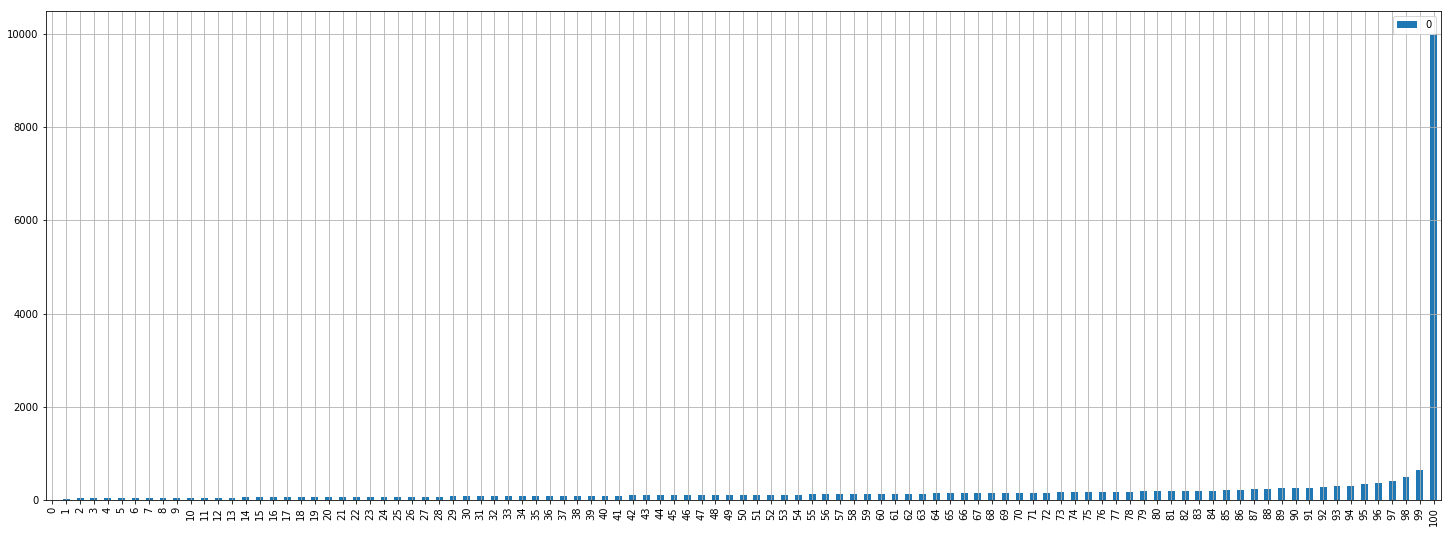

In [52]:
percentiles = list(range(0,101))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(25,9), grid=True)

In [53]:
display(
    price_percentile.iloc[99,:].values[0],
    price_percentile.iloc[1,:].values[0]
)

650.0

30.0

Considering that beyond the 99th percentile (approx. 650 USD) the data shoots up, we can consider value above it as outliers.

Similarly, we can remove everything below 1% percentile.

How many rows would we lose if we removed everything above 99 percentile?

In [54]:
listings_filtered = listings[listings["price"] <= price_percentile.iloc[99,:].values[0]]
listings_filtered = listings_filtered[listings_filtered["price"] >= price_percentile.iloc[1,:].values[0]]
listings_filtered["price"].describe()

count    39187.000000
mean       132.477684
std         91.465661
min         30.000000
25%         70.000000
50%        105.000000
75%        169.000000
max        650.000000
Name: price, dtype: float64

In [55]:
100 * (listings.shape[0] - listings_filtered.shape[0]) / listings.shape[0]

1.850924209788108

We lose less than 2% of rows upon dropping those outliers. Worth it.

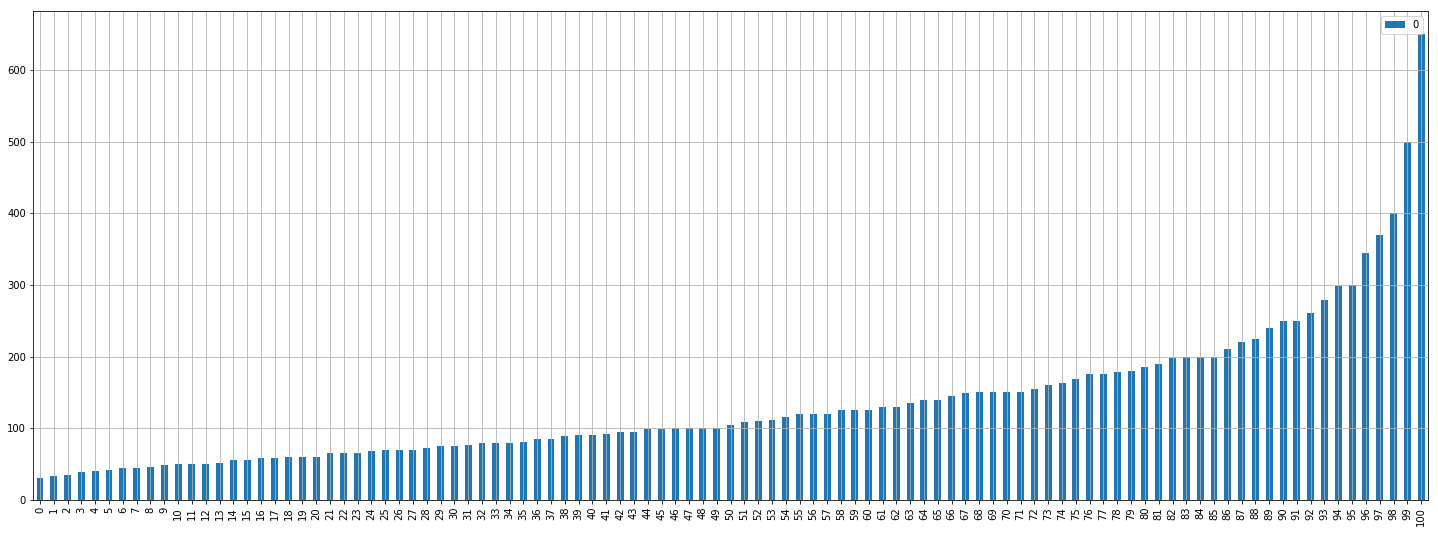

In [56]:
percentiles = list(range(0,101))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings_filtered['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(25,9), grid=True)

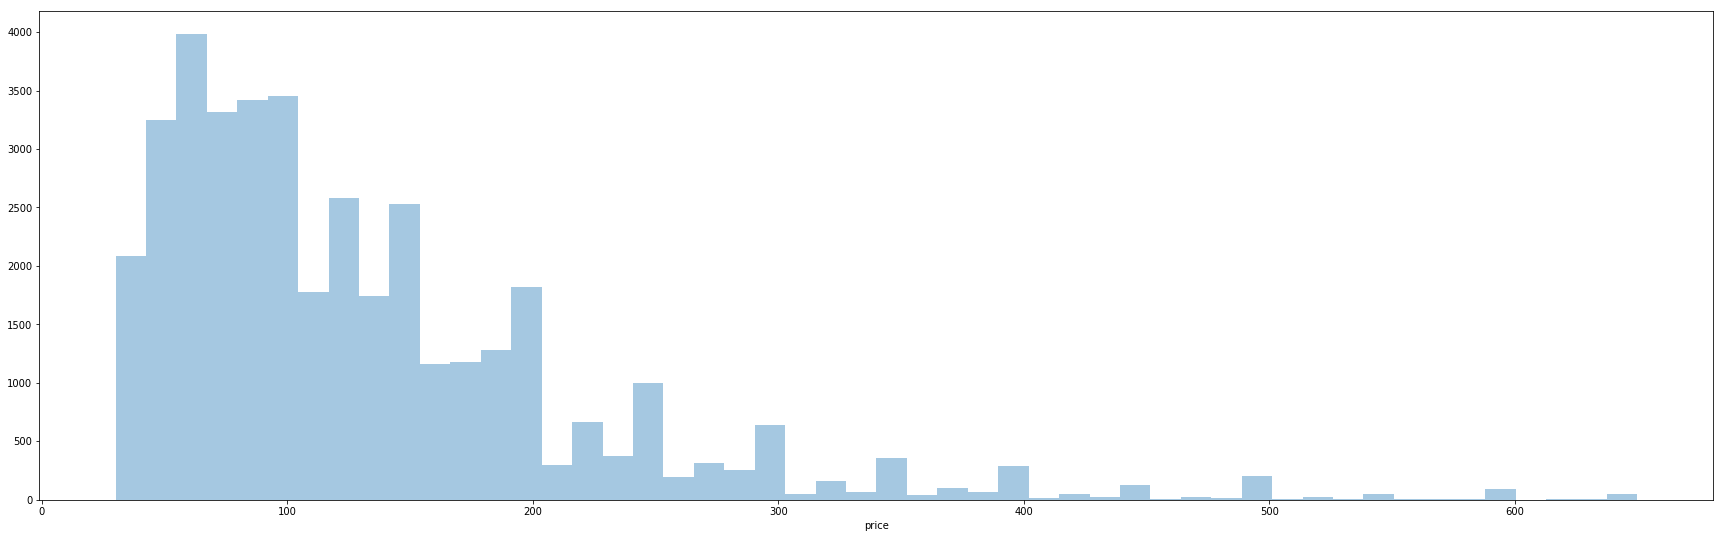

In [57]:
f, ax = plt.subplots(1,1,figsize=(30,9))
g = sns.distplot(listings_filtered["price"], kde=False, ax=ax)

## Rounding Prices 

For the sake of ease, what if we round the prices to the nearest multiple of 5?

In [58]:
base = 5
def roundto(row):
    return int(base * round(float(row)/base))
listings_filtered["price"] = listings_filtered["price"].apply(roundto)

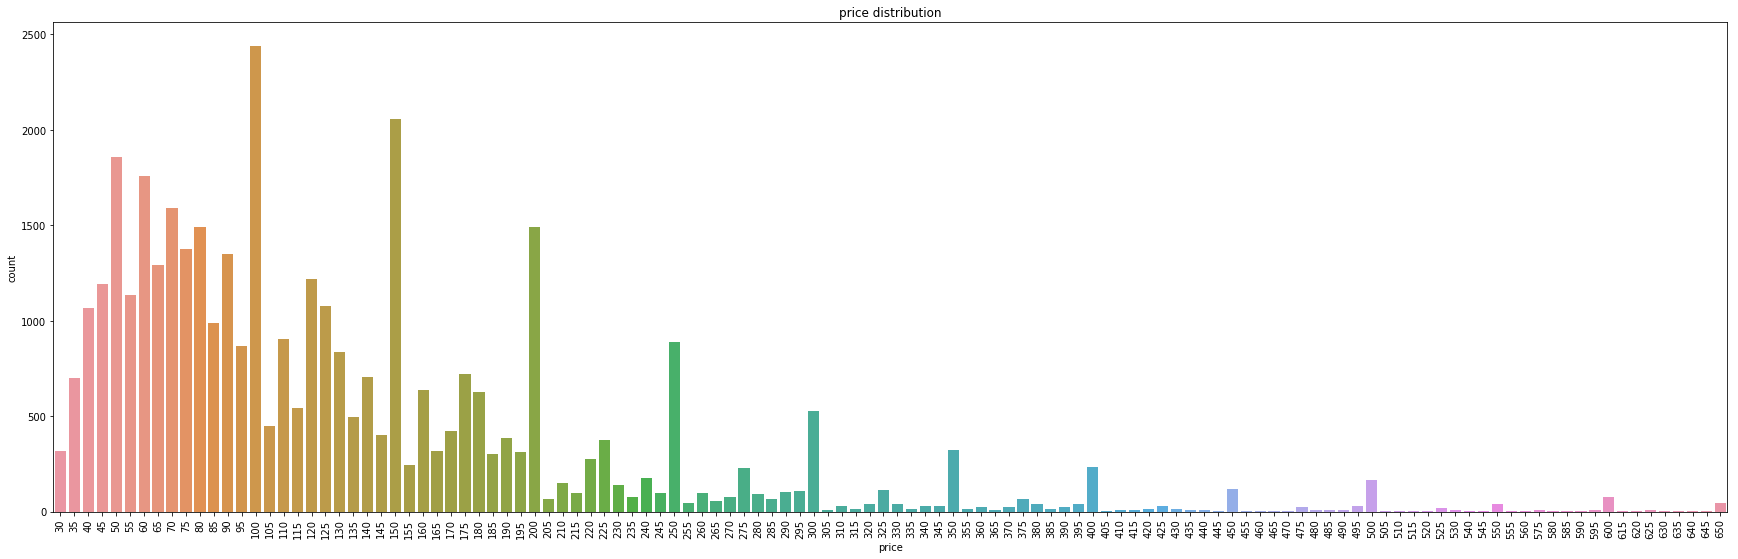

In [59]:
f, ax = plt.subplots(1,1,figsize=(30,9))
g = sns.countplot(x="price", data=listings_filtered, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")

## Preprocessing

In [60]:
ycol = ["price"]
xcol = [i for i in listings_filtered.columns if i not in ycol]
x = listings_filtered[xcol].values
y = listings_filtered[ycol].values

### 1. Standardisation

In [61]:
standard_scaler = StandardScaler()
x = standard_scaler.fit_transform(x)

### 2. Train test split

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)

### 3. Transformation

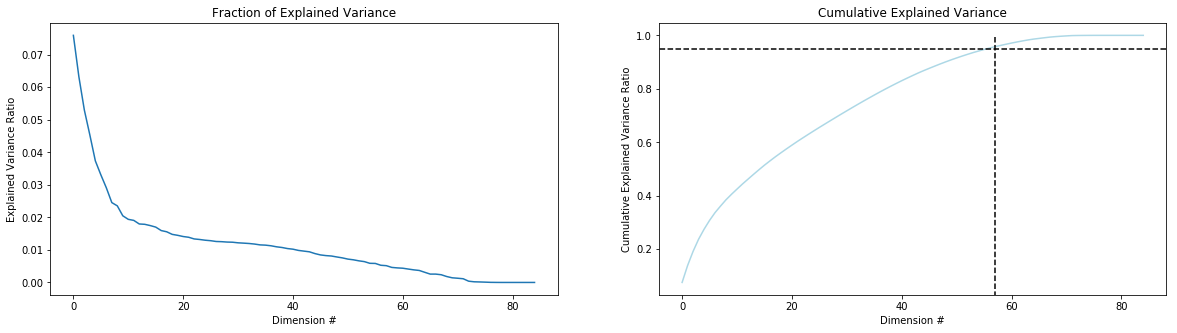

In [63]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)

In [64]:
pca = PCA(n_components=num_pc)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Prediction

In [65]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

In [66]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 26.59
Test set RMSE: 62.45


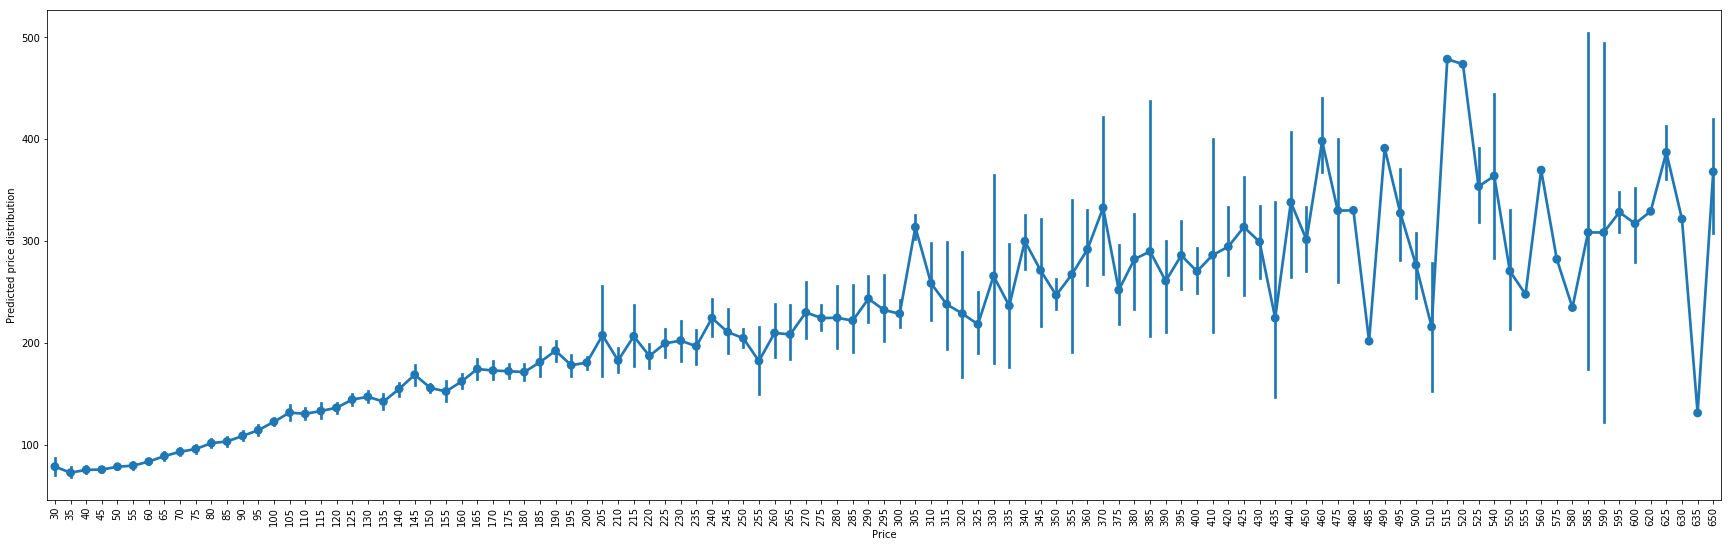

In [67]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test.ravel(), y=y_pred_test, ax=ax)
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [29]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

In [30]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 24.30
Test set RMSE: 56.42


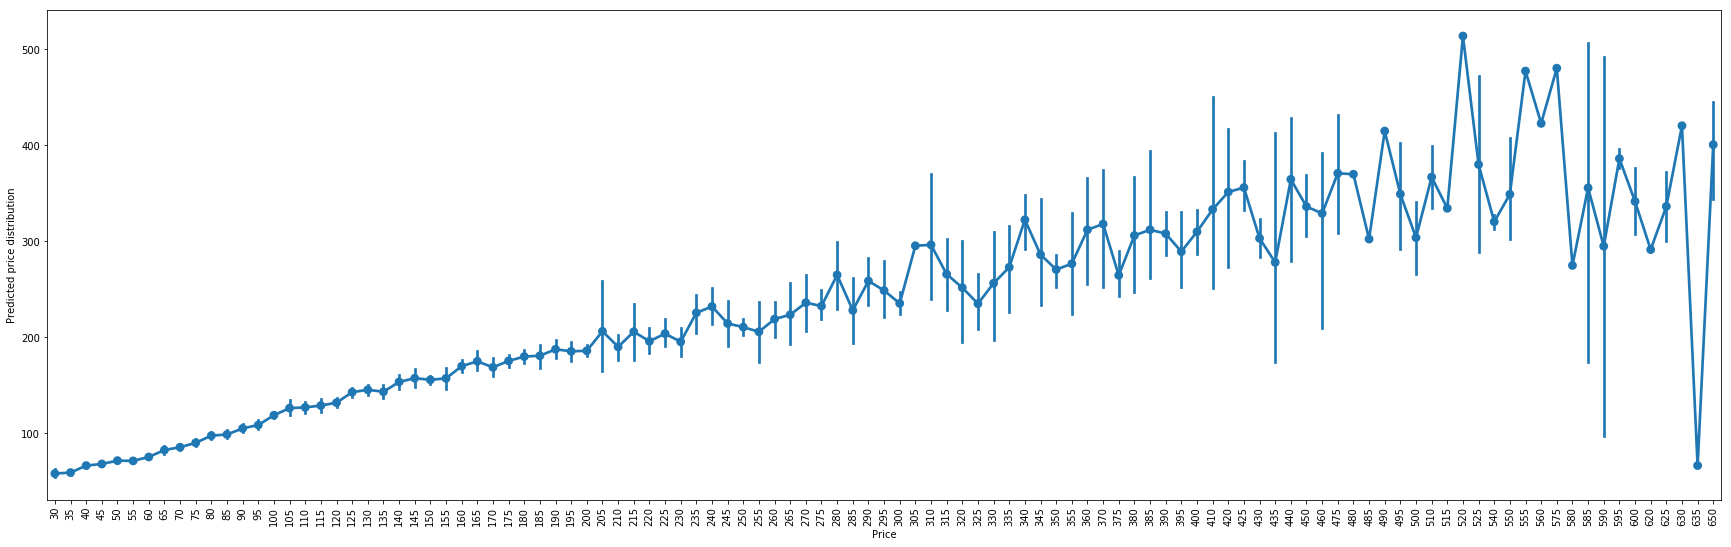

In [31]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test.ravel(), y=y_pred_test, ax=ax)
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Post Mortem analysis

What causes values beyond 250$ to not perform well for the random forest?

Let's get a count plot of all the bins we made

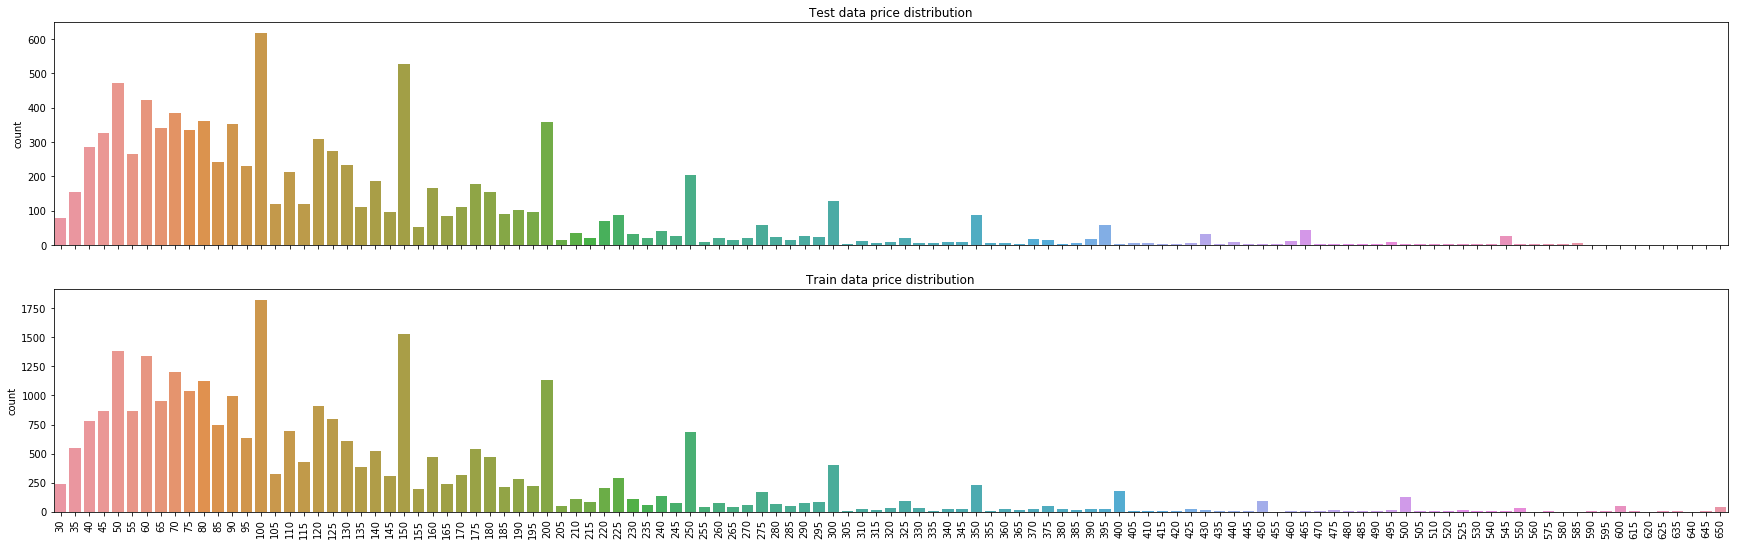

In [32]:
f, ax = plt.subplots(2, 1, figsize=(30,9), sharex=True)
g = sns.countplot(x=y_test.ravel(), ax=ax[0])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Test data price distribution")

g = sns.countplot(x=y_train.ravel(), ax=ax[1])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Train data price distribution")

Can we compensate for the lack of data points to even out the price distributions everywhere?

In [33]:
tmp = listings_filtered["price"].value_counts().to_frame()
tmp.reset_index(drop=False, inplace=True)
tmp.columns = ["price", "count"]
tmp.sort_values(by="price", inplace=True)
tmp.reset_index(drop=True, inplace=True)

In [34]:
tmp["count"].median()

61.0

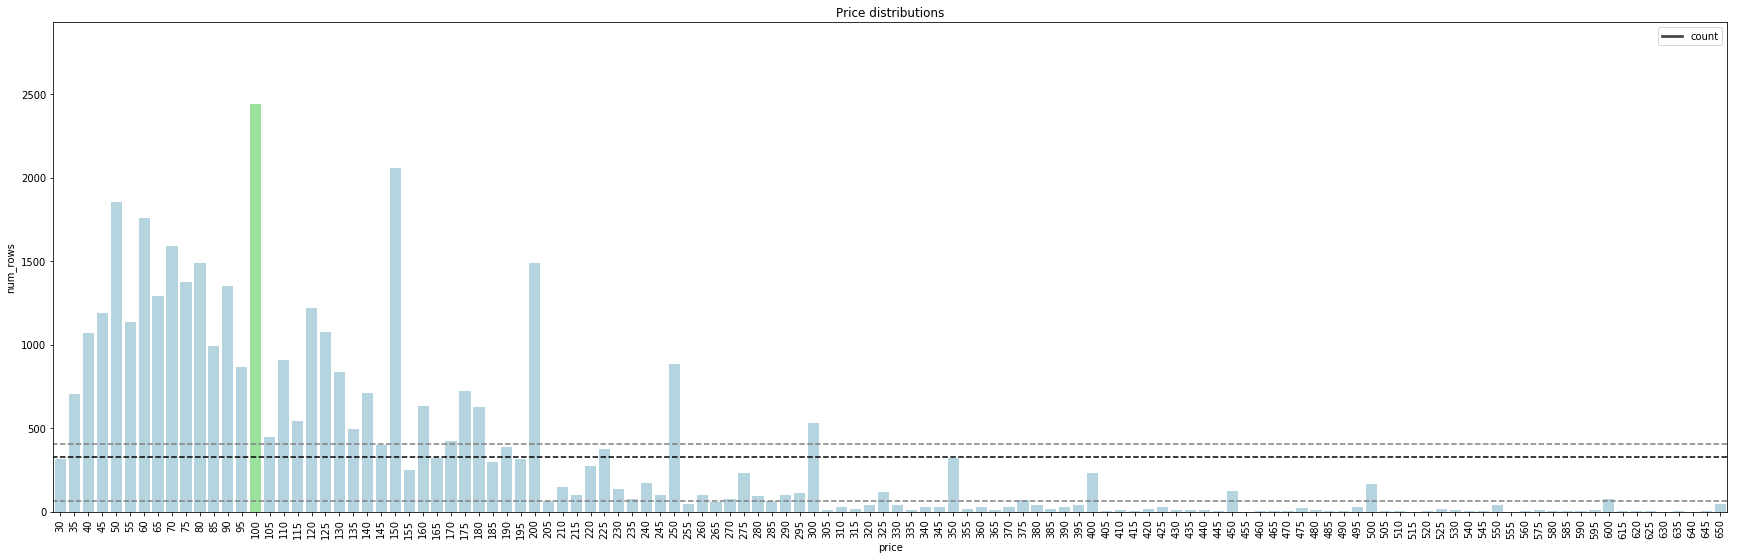

In [35]:
f, ax = plt.subplots(1, 1, figsize=(30,9))
plot_bar(x="price", y="count", data=tmp, ax=ax, xrot=90, legend=True, annot=False, plot_percentiles=[50, 75],
        title="Price distributions", xlabel="price", ylabel="num_rows")

We may need to generate synthetic samples for the imbalanced bins, thereby ensuring the classifier does not get biased towards the lower values. 

------------------

# Synthetic sample generation

First we identify what we consider as an under-represented sample. Make a separate column that decides that (binary flag column)

In [36]:
th = tmp["count"].mean()

def is_under_represented(row):
    if row < th:
        return 1
    return 0
tmp["flag_ur"] = tmp["count"].apply(is_under_represented)

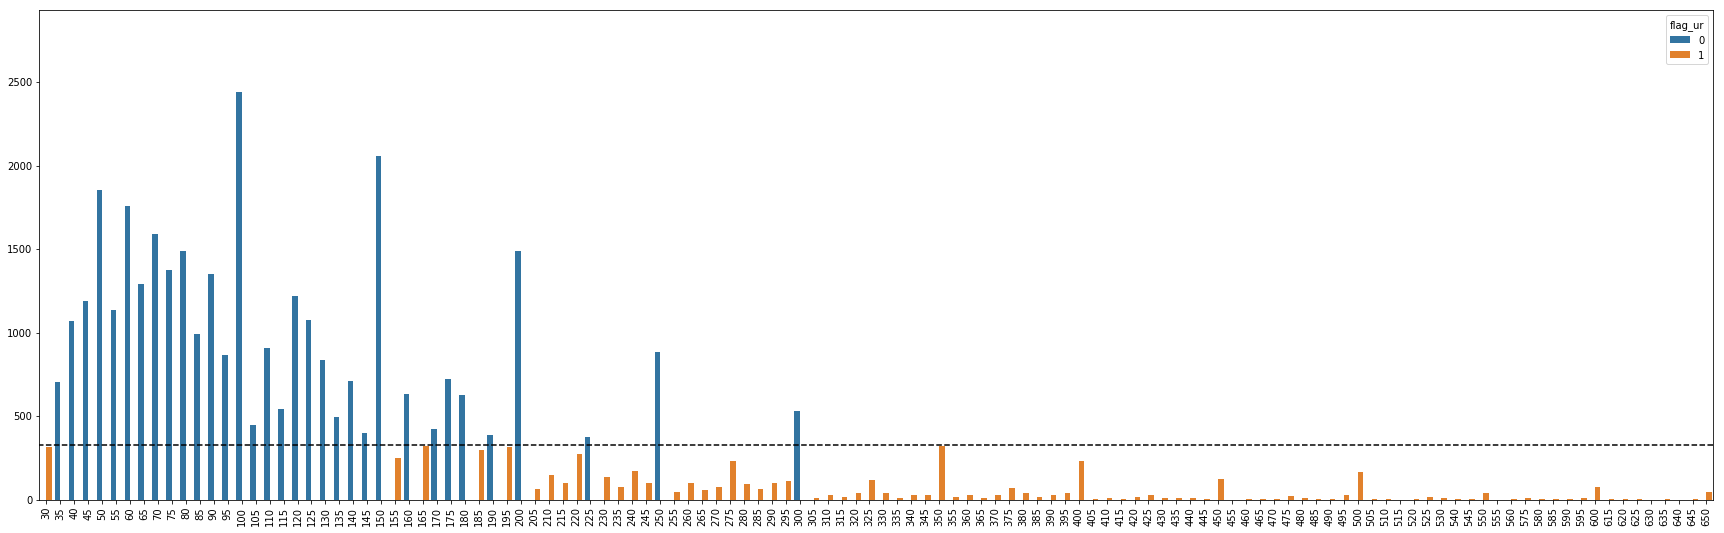

In [37]:
f, ax = plt.subplots(1, 1, figsize=(30,9))
plot_bar(x="price", y="count", hue="flag_ur", data=tmp, 
         ax=ax, highlight_max_min=False, annot=False, xrot=90)

In [38]:
listings = pd.read_csv(data_path, index_col="id")

percentiles = list(range(0,101))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')

listings_filtered = listings[listings["price"] <= price_percentile.iloc[99,:].values[0]]
listings_filtered = listings_filtered[listings_filtered["price"] >= price_percentile.iloc[1,:].values[0]]

In [39]:
def check_rep(row):
    if row <= 200:
        return 0
    elif (row > 200) & (row <= 300):
        return 1 
    elif (row > 300) & (row <= 400):
        return 2 
    elif (row > 400) & (row <= 500):
        return 3 
    else:
        return 4 

listings_filtered["flag_ur"] = listings_filtered["price"].apply(check_rep)

In [40]:
vcs = listings_filtered["flag_ur"].value_counts()
vcs

0    33565
1     3750
2     1138
3      475
4      259
Name: flag_ur, dtype: int64

In [41]:
ycol = ["flag_ur"]
xcol = [i for i in listings_filtered.columns if i not in ycol]

x = listings_filtered[xcol].values
y = listings_filtered[ycol].values

smote_sampling_strategy = {
    1: int(vcs[1]*2),
    2: int(vcs[1]*2),
    3: int(vcs[1]*2),
    4: int(vcs[1]*2)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)

x_new, y_new = sm.fit_sample(x, y)

# x_train_rare, x_test_rare, y_train_rare, y_test_rare = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)
# x_new, y_new = sm.fit_sample(x_train_rare, y_train_rare)

In [42]:
# Drop the flag column
listings_filtered.drop(labels=["flag_ur"], axis=1, inplace=True)

In [43]:
# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

price_index = get_index(list(listings_filtered.columns), "price")

In [311]:
y = x_new[:, price_index]
x = np.delete(x_new, price_index, axis=1)

In [312]:
y_new = []
for elem in y:
    y_new.append(roundto(elem))

y = y_new

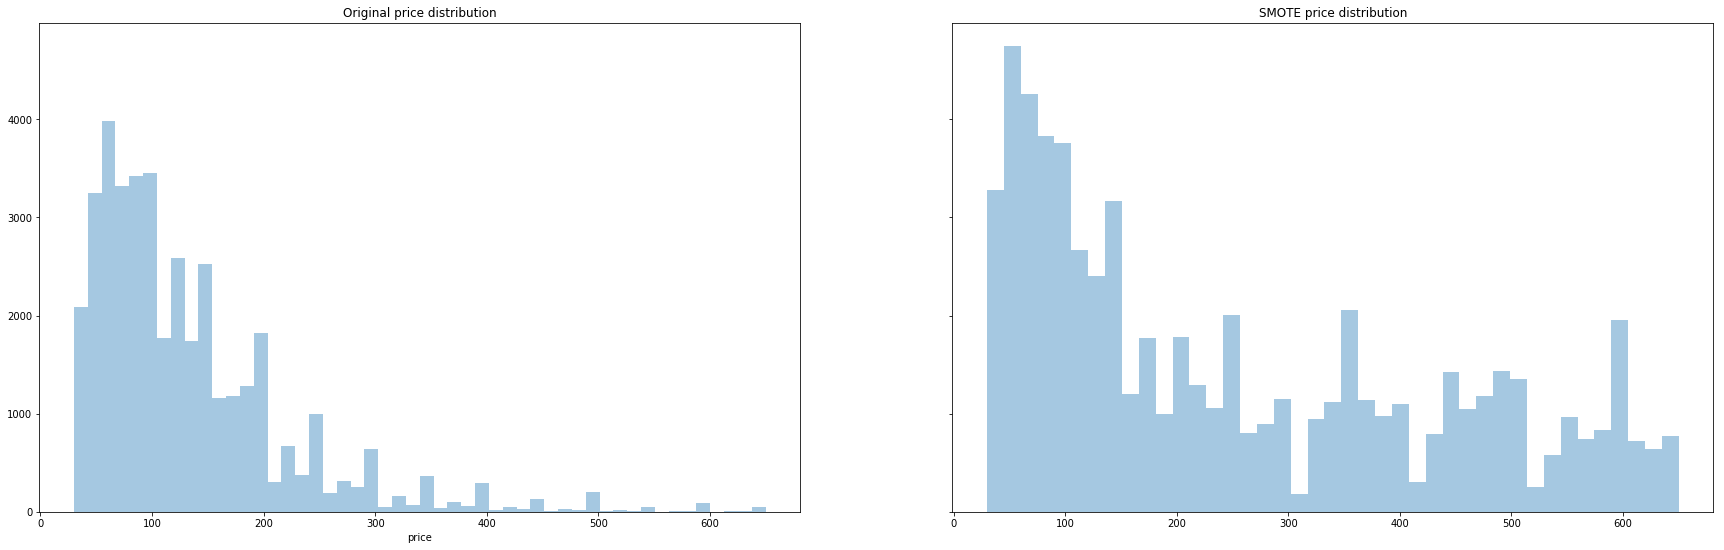

In [325]:
f, ax = plt.subplots(1, 2, figsize=(30, 9), sharey=True)
g1 = sns.distplot(listings_filtered["price"], ax=ax[0], kde=False)
t = g1.set_title("Original price distribution")

g2 = sns.distplot(y, ax=ax[1], kde=False)
t = g2.set_title("SMOTE price distribution")


### 1. Standardisation

In [314]:
standard_scaler = StandardScaler()
x = standard_scaler.fit_transform(x)

### 2. Train test split

In [315]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)

### 3. Transformation

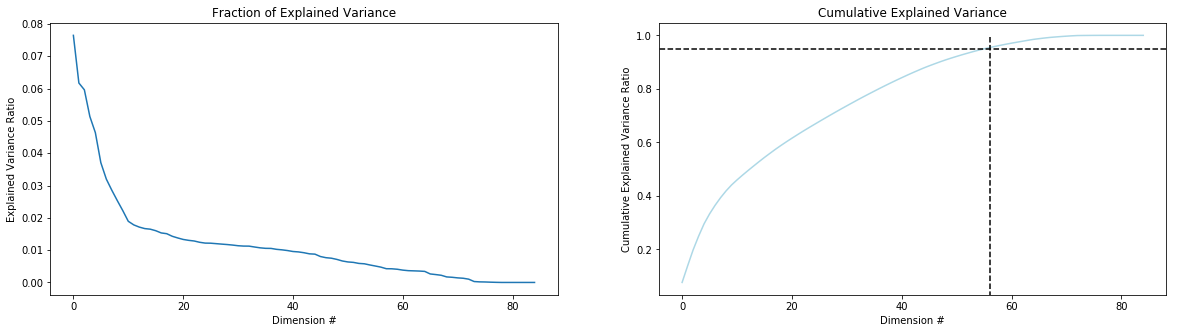

In [316]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)

In [317]:
pca = PCA(n_components=num_pc)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Prediction

In [318]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

In [319]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 28.81
Test set RMSE: 65.70


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

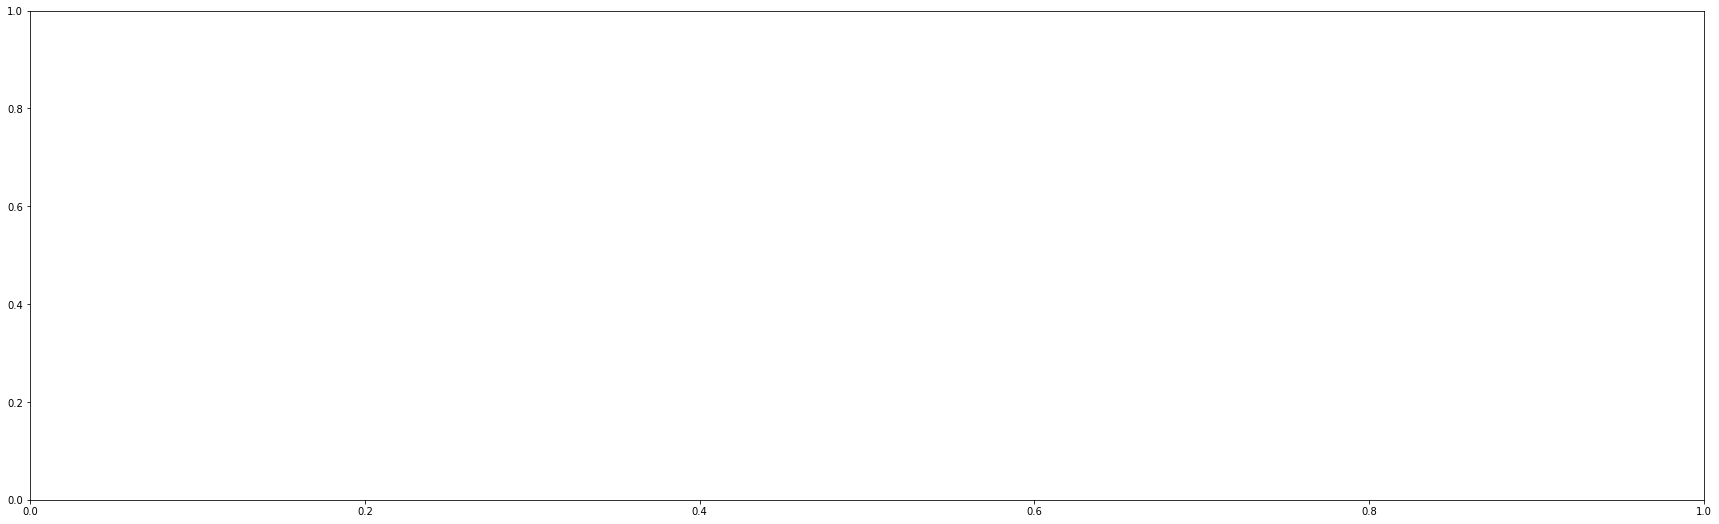

In [45]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("PCA")

In [321]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

In [322]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 23.77
Test set RMSE: 55.06


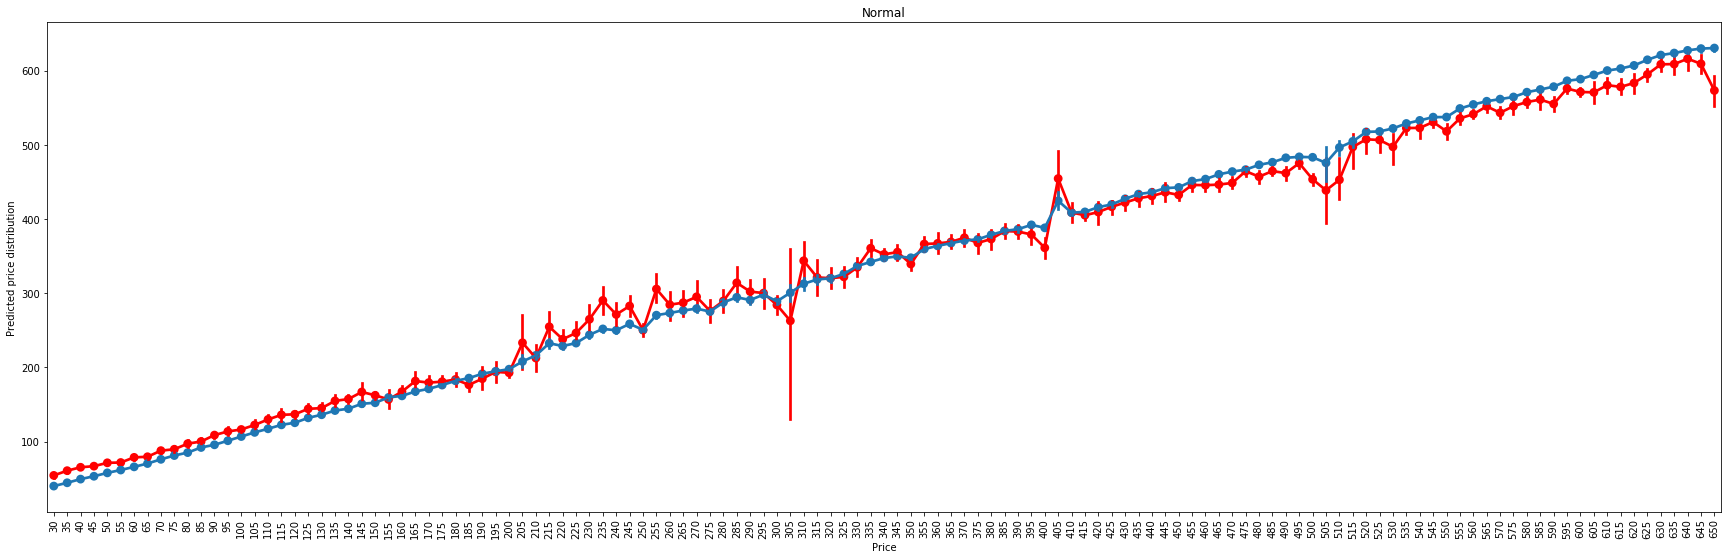

In [323]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

# Post Mortem analysis

What causes values beyond 250$ to not perform well for the random forest?

Let's get a count plot of all the bins we made

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(30,9), sharex=True)
g = sns.countplot(x=y_test, ax=ax[0])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Test data price distribution")

g = sns.countplot(x=y_train, ax=ax[1])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Train data price distribution")